In [9]:
# https://www.drivendata.org/competitions/4/page/15/#sub_values
# multi-class-multi-label classification problem, there are 9 broad categories that each take on many possible sub-label instances.
# we are predicting probabilities of certain labels with the goal of grouping the items.
# The submission must be 50064x104 where 50064 is the number of rows in the test dataset (excluding the header) and 104 is the number of columns (excluding a first column of row ids). The columns in the submission have the format ColumnName__PossibleLabel

# Education Resource Strategies is a non-profit that tackles to solve budget problem with the goal of letting districts be smarter, more strategic, and more effective in their spending.
# These labels let ERS understand how schools are spending money and tailor their strategy recommendations to improve outcomes for students, teachers, and administrators.

from platform import python_version
print("Python", python_version())

#import os
#print(os.getcwd())

Python 3.6.1


In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from datetime import timedelta

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier 

In [2]:
# Load data
# /home/radiance/Documents/datasets-7-7-17/ML_School_Budgets
df = pd.read_csv("/home/radiance/Documents/datasets-7-7-17/ML_School_Budgets/TrainingSet.csv", index_col=0) # 23 categories, 2 float
print(df.info()) # feautures that cannot be identified = object
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

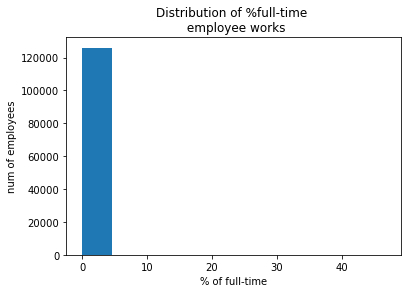

In [3]:
# fix this
# histogram of the non-null 'FTE' column
plt.hist(df['FTE'].dropna())
plt.title("Distribution of %full-time \n employee works")
plt.xlabel("% of full-time")
plt.ylabel("num of employees")
plt.show()

In [4]:
# Exploring datatypes in pandas
#print(df.dtypes)
#print(df.dtypes.value_counts()) # value_counts is Series method

# There are 9 columns of labels in the dataset. Each of these columns is a category that has many possible values it can take.
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status'] 
#print(df[LABELS])
#print(df[LABELS].dtypes) # object
#print(type(df[LABELS])) # DataFrame

# goal - predict the probability that a certain label is attached to a budget line item. 
# Encode the labels as categorical variables
categorize_label = lambda x: x.astype('category')

# .astype() only works on a pandas Series. Since you are working with a pandas DataFrame, you'll need to use the .apply() method and provide a lambda function called categorize_label that applies .astype() to each column, x.
df[LABELS] = df[LABELS].apply(categorize_label)
# Print the converted dtypes
print(df[LABELS].dtypes)

#df.label = df[[label]].apply(categorize_label, axis=0) # [[]] - dataframe
#df['Function'] = df['Function'].astype('category')
#df['Function'].head()

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


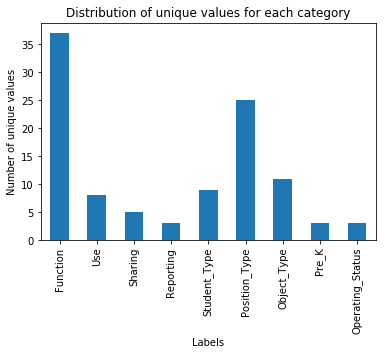

In [5]:
#Counting unique labels
# there are over 100 unique labels. count and plotting the number of unique values for each category of label.
df['Function'].unique()
df['Use'].unique()

# pandas - use pd.Series.nunique method for counting the number of unique values in a Series.
# Calculate number of unique values for each label: num_unique_labels
num_unique_values = df[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
# Create a bar plot of num_unique_labels
num_unique_values.plot(kind='bar')
plt.title("Distribution of unique values for each category")
plt.xlabel('Labels')
plt.ylabel('Number of unique values')
plt.show()

In [7]:
# Computing log loss with NumPy
def compute_log_loss(predicted,actual, eps=1e-14):
    logloss = -1 * np.mean(actual*np.log(predicted) + (1-actual)*np.log(1-predicted))
    return logloss

#Log loss penalizes highly confident wrong answers much more than any other type. This will be a good metric

In [10]:
# split the data into a training set and a test set. Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets. use the function to make sure the least min_count examples of each label appear in each split: multilabel_train_test_split.
# Building Simple model with just the numeric columns of your DataFrame

NUMERIC_COLUMNS = ['FTE','Total']
#df[NUMERIC_COLUMNS]

# Create the new DataFrame: numeric_data_only
# We are replacing -1000 with NAN so as to differentiate from 0
numeric_data_only = pd.DataFrame(df[NUMERIC_COLUMNS]).fillna(-1000)

# Dummy variable encoding - binary indicator representation
# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS], prefix_sep="_")

import sys
# the ML_School_Budgets contains multilabel.py
sys.path.append('/home/radiance/Documents/datasets-7-7-17/ML_School_Budgets')

# Import multilabel_train_test_split from /home/radiance/Documents/datasets-7-7-17/ML_School_Budgets/multilabel.py
from multilabel import multilabel_train_test_split

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 


X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
FTE      320222 non-null float64
Total    320222 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 72072
Data columns (total 2 columns):
FTE      80055 non-null float64
Total    80055 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 72072
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 8.6 MB
None


In [11]:
# Training a model
# as we're throwing away all of the text data in the dataset - that's by far most of the data! So no killer performance.

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

# The bad news is that your model scored the lowest possible accuracy: 0.0! But hey, you just threw away ALL of the text data in the budget. Later, you won't. Before you add the text data, let's see how the model does when scored by log loss.

Accuracy: 0.0


In [14]:
# Use your model to predict values on holdout data
# The original goal is to predict the probability of each label. use the .predict_proba() method on your trained model.
# from time import time

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())
start = time()
print("Started training classifier")
# Fit it to the training data
clf.fit(X_train, y_train)
print("Time taken to train classifier: {}".format(timedelta(seconds=time() - start)))

Started training classifier
Time taken to train classifier: 0:05:29.860768


In [16]:
# Creating a bag-of-words in scikit-learn
# focus on one feature Position_Extra column, which describes any additional information not captured by the Position_Type label like df.loc[8960]
# Position_Extra has lots of NaN

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace=True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])
# Treating only alpha-numeric characters as tokens gives you a smaller number of more meaningful tokens. You've got bag-of-words in the bag!

There are 385 tokens in Position_Extra if we split on non-alpha numeric
['1st', '2nd', '3rd', '4th', '56', '5th', '9th', 'a', 'ab', 'accountability', 'adaptive', 'addit', 'additional', 'adm', 'admin']


In [17]:
# Combining text columns for tokenization
# CountVectorizer expects each row to just be a single string, so in order to use all of the text columns, you'll need a method to turn a list of strings into a single string.
# this function will convert all training text data in your DataFrame to a single string per row that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.

# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [18]:
# Now you will use combine_text_columns to convert all training text data in your DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
# this regex splits on whitespace
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
# Fit parses the data and creates a vocabulary, while Transform tokenize text and produce an array of counts
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 4758 tokens in the dataset
There are 3284 alpha-numeric tokens in the dataset


In [19]:
# Using FunctionTransformer on the main dataset
# using FunctionTransformer on the primary budget data, before instantiating a multiple-datatype pipeline
# custom function combine_text_columns to select and properly format text data for tokenization
# Concerning the numeric data, you can use NUMERIC_COLUMNS, preloaded as usual, to help design a subset-selecting lambda function.

# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)


In [21]:
# Add a model to the pipeline
# The structure of the pipeline
# the preprocessing step uses FeatureUnion to join the results of nested pipelines that each rely on FunctionTransformer to select multiple datatypes
# the model step stores the model object

from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector',get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = time()
print("Started training classifier")
# Fit it to the training data
pl.fit(X_train, y_train)
print("Time taken to train classifier: {}".format(timedelta(seconds=time() - start)))

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

Started training classifier
Time taken to train classifier: 0:15:11.268339

Accuracy on budget dataset:  0.351258509775


In [22]:
# adjusting the model or parameters to improve accuracy?
# Updating the parameters n_estimators of RandomForestClassifier(), whose default value is 10, to 15.

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Add model step to pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

start = time()
print("Started training classifier")
# Fit it to the training data
pl.fit(X_train, y_train)
print("Time taken to train classifier: {}".format(timedelta(seconds=time() - start)))

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)
# It's time to get serious and work with the log loss metric.

Started training classifier
Time taken to train classifier: 0:06:50.485994

Accuracy on budget dataset:  0.912759977515


In [23]:
# Using CountVectorizer on the training data X_train to see the effect of tokenization on punctuation. Remember, since CountVectorizer expects a vector, combine_text_columns before fitting to the training data.
# Importing the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the text vector
text_vector = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer: text_features
text_features = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

start = time()
print("Started fiting text_vector...")
# Fit text_features to the text vector
text_features.fit(text_vector)
print("Total time taken to train text_vector: {}".format(timedelta(seconds=time() - start)))

# Print the first 10 tokens
print(text_features.get_feature_names()[:10])

Started fiting text_vector...
Total time taken to train text_vector: 0:00:07.429016
['00a', '12', '1st', '2nd', '3rd', '4th', '5', '56', '5th', '6']


In [24]:
# N-gram range - look for ngram relationships at multiple scales, you will use the ngram_range parameter - 1,2
# Adding dim_red step & scale step
# Apply dimensionality reduction technique - dim_red step. we have to scale the features to lie between -1 and 1 using scale step.
# The dim_red step uses SelectKBest(), applying chi-squared test to select the K "best" features. The scale step uses MaxAbsScaler() in order to squash the relevant features into the interval -1 to 1.

# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 300 best features
chi_k = 300

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

start = time()
print("Started training classifier")
# Fit it to the training data
pl.fit(X_train, y_train)
print("Time taken to train classifier: {}".format(timedelta(seconds=time() - start)))

# Log loss score: 1.2681.

Started training classifier
Time taken to train classifier: 0:07:32.167802


In [29]:
# interaction modeling with SparseInteractions - Interaction terms are a statistical tool that lets your model express what happens if two features appear together in the same row.
# considering interaction terms of degree=2
# interaction terms - take long to train - making n features into n-squared features

from SparseInteractions import SparseInteractions

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

print("Started training classifier")
# Fit it to the training data
pl.fit(X_train, y_train)
# Log loss score: 1.2256. Nice improvement from 1.2681!

Started training classifier


Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_features', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x7fe9fa912730>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='dep...=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [30]:
# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.787508587846


In [26]:
# using hashing trick?
# a hash function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.
# Enforcing a fixed length can speed up calculations drastically, especially on large datasets!
# Hashing vectorizer is very low memory scalable to large datasets as there is no need to store a vocabulary dictionary in memory,   it is fast to pickle and un-pickle as it holds no state besides the constructor parameters, it can be used in a streaming (partial fit) or parallel pipeline as there is no state computed during fit.

# Implementing the hashing trick in scikit-learn
# HashingVectorizer acts just like CountVectorizer in that it can accept token_pattern and ngram_range parameters. The important difference is that it creates hash values from the text, so that we get all the computational advantages of hashing!

# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
hashing_vec = HashingVectorizer(norm=None,non_negative=True,token_pattern=TOKENS_ALPHANUMERIC,ngram_range=(1,2))

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)

# Create DataFrame and print the head
hashed_df = pd.DataFrame(hashed_text.data)
print(hashed_df.head())

/home/radiance/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/radiance/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


     0
0  1.0
1  1.0
2  2.0
3  1.0
4  1.0


In [ ]:
# Final model
# add the HashingVectorizer step to the pipeline to replace the CountVectorizer step.

# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate the winning model pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

print("Started training classifier")
# Fit it to the training data
pl.fit(X_train, y_train)
print("Time taken to train classifier: {}".format(timedelta(seconds=time() - start)))

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Started training classifier


/home/radiance/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
/home/radiance/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)
